In [3]:
from collections import Counter
import re

import matplotlib.pyplot as plt
import numpy as np
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import pandas as pd
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer
from wordcloud import WordCloud

In [4]:
df = pd.read_csv('https://raw.githubusercontent.com/Himanshu-1703/reddit-sentiment-analysis/refs/heads/main/data/reddit.csv')
df.head()

,clean_comment,category
0,family mormon have never tried explain them t...,1
1,buddhism has very much lot compatible with chr...,1
2,seriously don say thing first all they won get...,-1
3,what you have learned yours and only yours wha...,0
4,for your own benefit you may want read living ...,1


In [5]:
df.shape

(37249, 2)

In [6]:
df.sample()['clean_comment'].values

array([' shocking incident bjp workers allegedly asked muslim corporators uttar pradesh meerut district sing vande mataram quit india times now reported thursday new delhi shocking incident bjp workers allegedly asked muslim corporators uttar pradesh meerut district sing vande mataram quit india times now reported thursday the incident took place march when muslim corporators claimed they were forced the saffron party members sing the indian national song during meerut municipal corporation meeting respect vande mataram but bjp corporators and mayor were literally forcing sing afzal corporator told ani the supreme court says not mandatory afzal added meanwhile according ani the city municipal corporation has prohibited some members from attending meeting they had refused sing the national song this diktat comes despite the uttar pradesh chief minister yogi adityananth promise that there will discrimination the basis caste and religion the state and his government main goal would develo

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37249 entries, 0 to 37248
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   clean_comment  37149 non-null  object
 1   category       37249 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 582.1+ KB


In [8]:
df.isnull().sum()

clean_comment    100
category           0
dtype: int64

In [9]:
df[df['clean_comment'].isna()]

,clean_comment,category
413,NaN,0
605,NaN,0
2422,NaN,0
2877,NaN,0
3307,NaN,0
...,...,...
35975,NaN,0
36036,NaN,0
37043,NaN,0
37111,NaN,0


In [10]:
df[df['clean_comment'].isna()]['category'].value_counts()

category
0    100
Name: count, dtype: int64

In [11]:
df.dropna(inplace=True)

In [12]:
df.duplicated().sum()

np.int64(350)

In [13]:
df[df.duplicated()]

,clean_comment,category
375,,0
392,,0
617,aurum mom,0
651,,0
1222,,0
...,...,...
36915,who won,0
37044,,0
37125,hari,0
37158,top kek,1


In [14]:
df.drop_duplicates(inplace=True)

In [15]:
df[(df['clean_comment'].str.strip() == '')]

,clean_comment,category
181,,0
4432,\n,0
10592,,0
16173,,0
32149,\n,0
34959,,0


In [16]:
df = df[~(df['clean_comment'].str.strip() == '')]

In [17]:
# Convert the 'clean_comment' column to lowercase
df.loc[:, 'clean_comment'] = df['clean_comment'].str.lower()

In [18]:
# Remove trailing and leading whitespaces from the 'clean_comment' column
df.loc[:, 'clean_comment'] = df['clean_comment'].str.strip()

In [19]:
# Identify comments containing URLs
url_pattern = r'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\\(\\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+'
comments_with_urls = df[df['clean_comment'].str.contains(url_pattern, regex=True)]

# Display the comments containing URLs
comments_with_urls.head()

,clean_comment,category


In [20]:
# Remove new line characters from the 'clean_comment' column
df.loc[:, 'clean_comment'] = df['clean_comment'].str.replace('\n', ' ', regex=True)

# EDA

<Axes: xlabel='category', ylabel='count'>

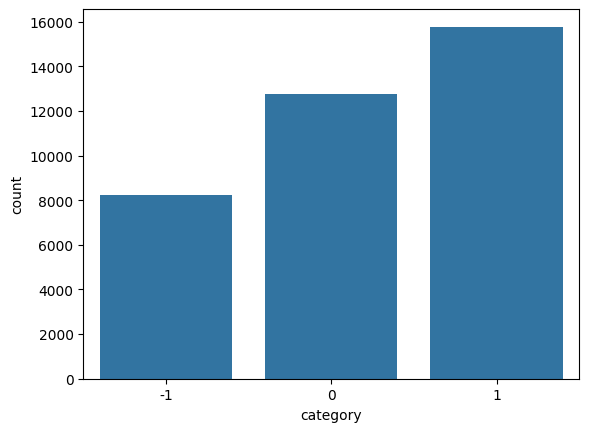

In [21]:
# distribution of classes
sns.countplot(data=df,x="category")

In [22]:
# frequency distribution of sentiments
df['category'].value_counts(normalize=True).mul(100).round(2)

category
 1    42.86
 0    34.71
-1    22.42
Name: proportion, dtype: float64

In [23]:
df['word_count'] = df['clean_comment'].apply(lambda x: len(x.split()))

In [24]:
df.sample(5)

,clean_comment,category,word_count
3316,ugh this horrible what shitty excuses for huma...,-1,12
25249,when visiting india,0,3
2304,can walk the talk removing astrology courses u...,-1,15
787,have said time and again most people arent sha...,1,85
18877,your perspective has started change because th...,0,16


In [25]:
df['word_count'].describe()

count    36793.000000
mean        29.667464
std         56.790738
min          1.000000
25%          6.000000
50%         13.000000
75%         30.000000
max       1307.000000
Name: word_count, dtype: float64

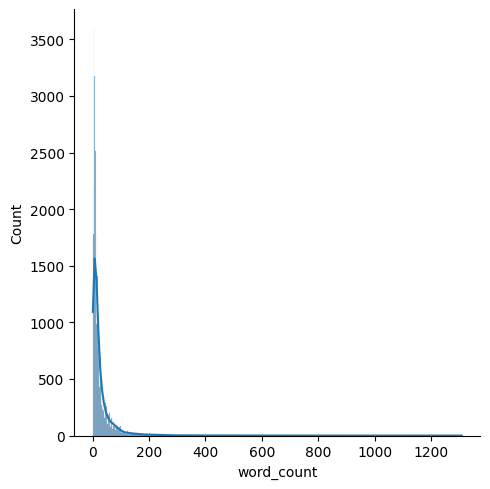

In [26]:
sns.displot(df['word_count'], kde=True)

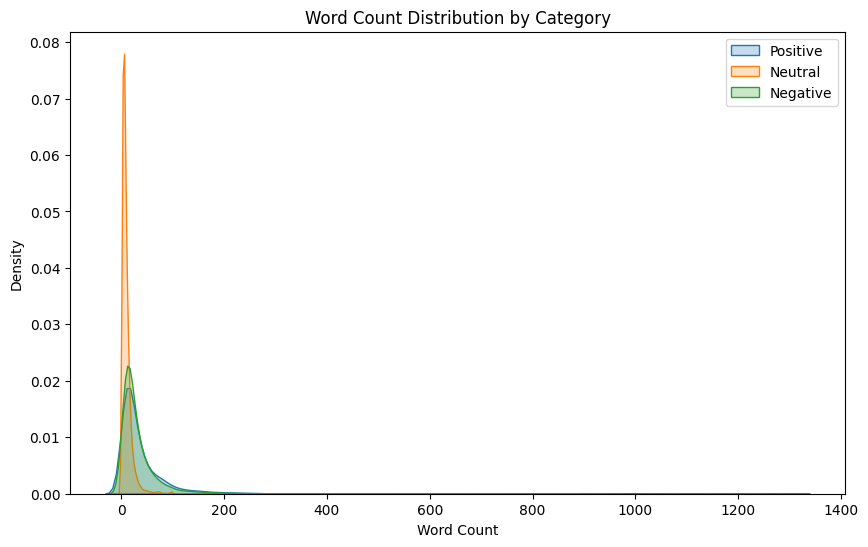

In [27]:
# Create the figure and axes
plt.figure(figsize=(10, 6))

# Plot KDE for category 1
sns.kdeplot(df[df['category'] == 1]['word_count'], label='Positive', fill=True)

# Plot KDE for category 0
sns.kdeplot(df[df['category'] == 0]['word_count'], label='Neutral', fill=True)

# Plot KDE for category -1
sns.kdeplot(df[df['category'] == -1]['word_count'], label='Negative', fill=True)

# Add title and labels
plt.title('Word Count Distribution by Category')
plt.xlabel('Word Count')
plt.ylabel('Density')

# Add a legend
plt.legend()

# Show the plot
plt.show()

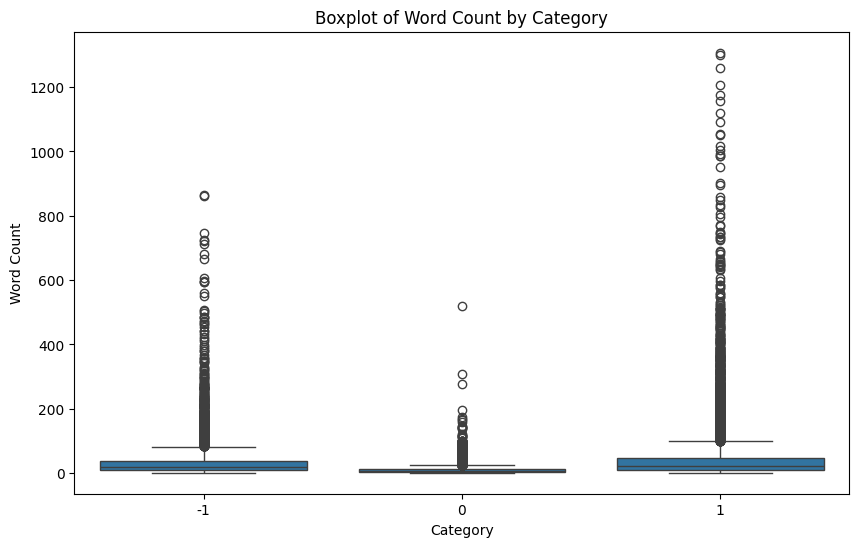

In [28]:
# sns.boxplot(df['word_count'])
# Create a boxplot for the 'wordcount' column categorized by 'category'
plt.figure(figsize=(10, 6))
sns.boxplot(data=df, x='category', y='word_count')
plt.title('Boxplot of Word Count by Category')
plt.xlabel('Category')
plt.ylabel('Word Count')
plt.show()

<Axes: xlabel='category', ylabel='word_count'>

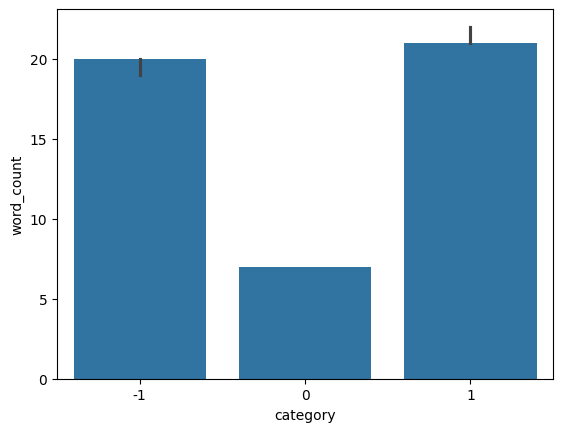

In [29]:
# median word counts among sentiments

sns.barplot(df,x='category',y='word_count',estimator='median')

In [30]:
# Download NLTK stopwords if not already downloaded
nltk.download('stopwords')

# Define the list of English stopwords
stop_words = set(stopwords.words('english'))

# Create a new column 'num_stop_words' by counting the number of stopwords in each comment
df['num_stop_words'] = df['clean_comment'].apply(lambda x: len([word for word in x.split() if word in stop_words]))

df.sample(5)

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/sudarshan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,clean_comment,category,word_count,num_stop_words
28227,that misquote this was actually said ron paul ...,-1,11,3
29159,his mann baat doesn care about your mann baat,0,9,4
33431,itne chowkidaar ban gye mai thoda aaram kar le...,-1,19,6
30317,interesting and shocking read why won these st...,-1,16,7
4956,this would achieve nothing except maybe bring ...,-1,47,17


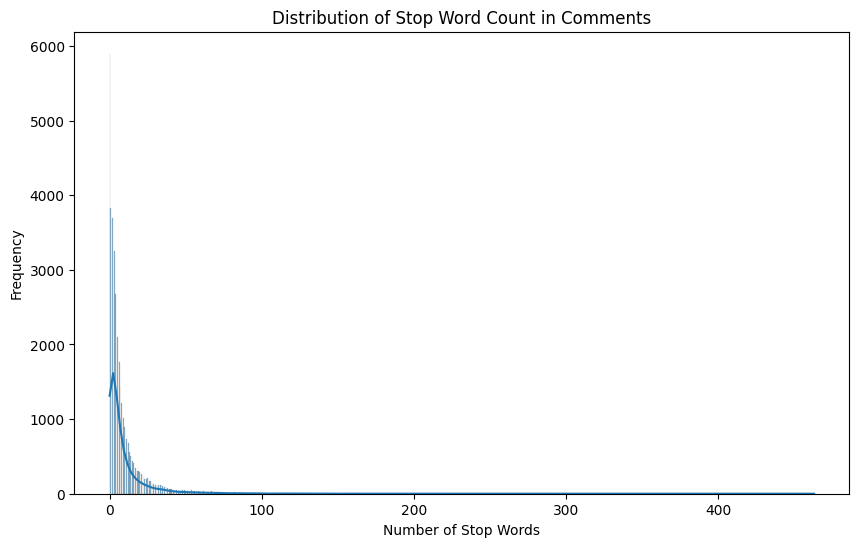

In [31]:
# Create a distribution plot (displot) for the 'num_stop_words' column
plt.figure(figsize=(10, 6))
sns.histplot(df['num_stop_words'], kde=True)
plt.title('Distribution of Stop Word Count in Comments')
plt.xlabel('Number of Stop Words')
plt.ylabel('Frequency')
plt.show()

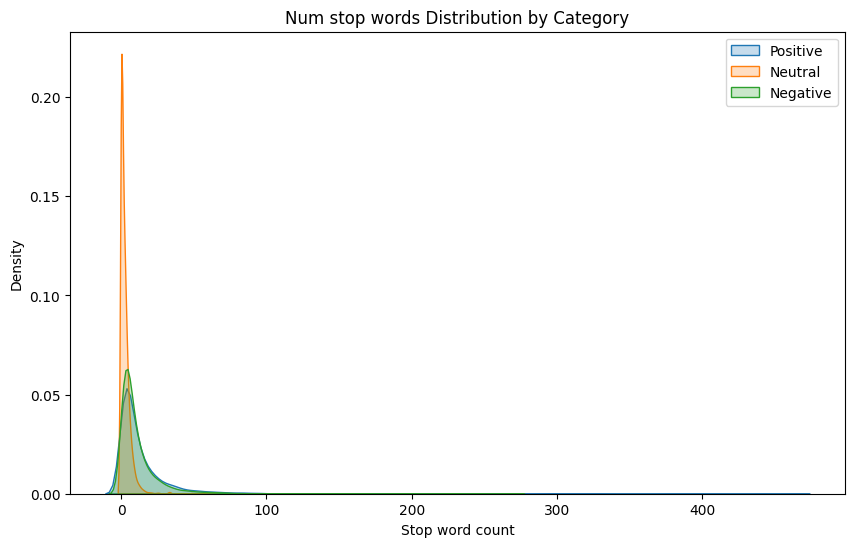

In [32]:
# Create the figure and axes
plt.figure(figsize=(10, 6))

# Plot KDE for category 1
sns.kdeplot(df[df['category'] == 1]['num_stop_words'], label='Positive', fill=True)

# Plot KDE for category 0
sns.kdeplot(df[df['category'] == 0]['num_stop_words'], label='Neutral', fill=True)

# Plot KDE for category -1
sns.kdeplot(df[df['category'] == -1]['num_stop_words'], label='Negative', fill=True)

# Add title and labels
plt.title('Num stop words Distribution by Category')
plt.xlabel('Stop word count')
plt.ylabel('Density')

# Add a legend
plt.legend()

# Show the plot
plt.show()

<Axes: xlabel='category', ylabel='num_stop_words'>

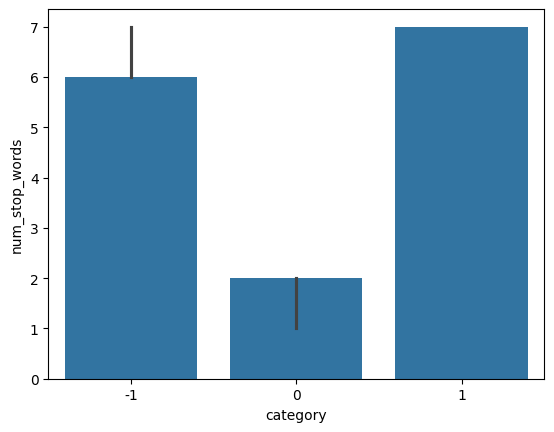

In [33]:
# median word counts among sentiments

sns.barplot(df,x='category',y='num_stop_words',estimator='median')

/tmp/ipykernel_37011/3596963344.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_25_df, x='count', y='stop_word', palette='viridis')


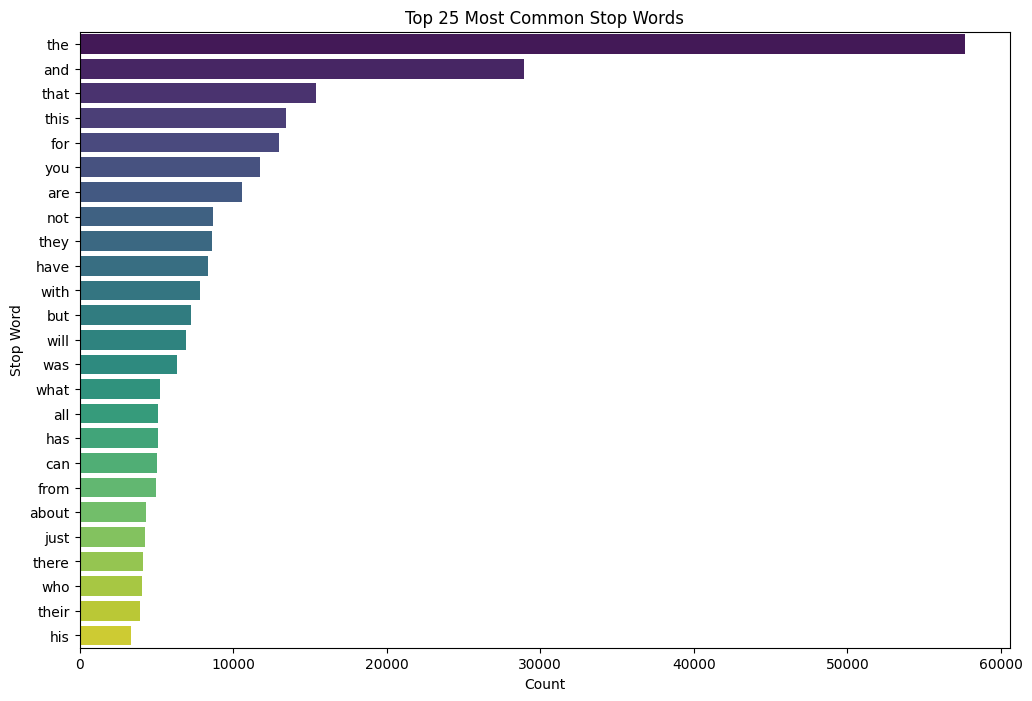

In [34]:
# Create a frequency distribution of stop words in the 'clean_comment' column
# Extract all stop words from the comments using the previously defined 'common_stopwords'
all_stop_words = [word for comment in df['clean_comment'] for word in comment.split() if word in stop_words]

# Count the most common stop words
most_common_stop_words = Counter(all_stop_words).most_common(25)

# Convert the most common stop words to a DataFrame for plotting
top_25_df = pd.DataFrame(most_common_stop_words, columns=['stop_word', 'count'])

# Create the barplot for the top 25 most common stop words
plt.figure(figsize=(12, 8))
sns.barplot(data=top_25_df, x='count', y='stop_word', palette='viridis')
plt.title('Top 25 Most Common Stop Words')
plt.xlabel('Count')
plt.ylabel('Stop Word')
plt.show()

In [35]:
df['num_chars'] = df['clean_comment'].apply(len)

df.head()

,clean_comment,category,word_count,num_stop_words,num_chars
0,family mormon have never tried explain them th...,1,39,13,259
1,buddhism has very much lot compatible with chr...,1,196,59,1268
2,seriously don say thing first all they won get...,-1,86,40,459
3,what you have learned yours and only yours wha...,0,29,15,167
4,for your own benefit you may want read living ...,1,112,45,690


In [36]:
df['num_chars'].describe()

count    36793.000000
mean       181.852798
std        359.702163
min          1.000000
25%         38.000000
50%         80.000000
75%        184.000000
max       8664.000000
Name: num_chars, dtype: float64

In [37]:
# Create a new column 'num_punctuation_chars' to count punctuation characters in each comment
df['num_punctuation_chars'] = df['clean_comment'].apply(
    lambda x: sum([1 for char in x if char in '.,!?;:"\'()[]{}-'])
)

df.sample(5)

,clean_comment,category,word_count,num_stop_words,num_chars,num_punctuation_chars
20355,this types scene usually occurs old bollywood ...,1,42,15,253,0
24789,stop fighting dead enemies and stop fighting f...,1,21,8,122,0
30960,worst ama ever,-1,3,0,14,0
14672,thank you for writing this have been procrasti...,0,14,8,88,0
19877,dont like pubic display bigotry,0,5,0,31,0


In [38]:
df['num_punctuation_chars'].describe()

count    36793.0
mean         0.0
std          0.0
min          0.0
25%          0.0
50%          0.0
75%          0.0
max          0.0
Name: num_punctuation_chars, dtype: float64

In [39]:
# Combine all comments into one large string
all_text = ' '.join(df['clean_comment'])

# Count the frequency of each character
char_frequency = Counter(all_text)

# Convert the character frequency into a DataFrame for better display
char_frequency_df = pd.DataFrame(char_frequency.items(), columns=['character', 'frequency']).sort_values(by='frequency', ascending=False)
char_frequency_df['character'].values

array([' ', 'e', 't', ..., '呗', 'ഥ', '杨'], shape=(1378,), dtype=object)

In [40]:
char_frequency_df.tail(50)

,character,frequency
1336,回,1
1337,毫,1
1322,足,1
1323,够,1
1324,假,1
1325,才,1
1326,叫,1
1327,醒,1
1328,妖,1
1329,婆,1


/tmp/ipykernel_37011/2098965077.py:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_25_bigrams_df, x='count', y='bigram', palette='magma')


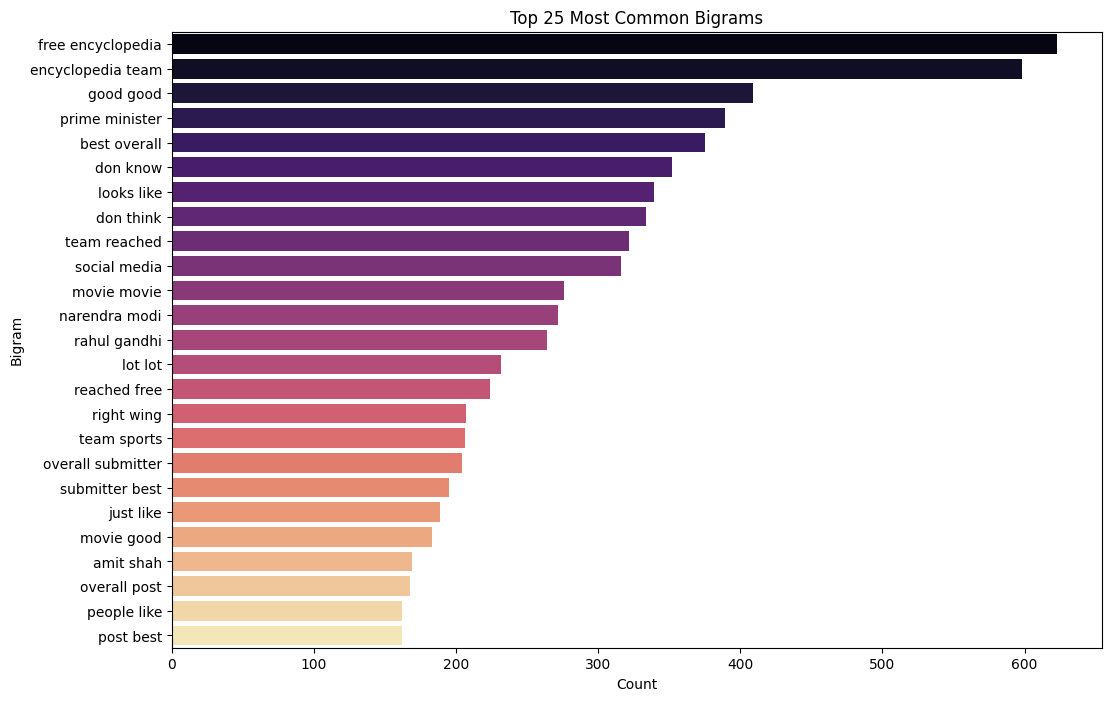

In [41]:
# Create a function to extract the top 25 bigrams
def get_top_ngrams(corpus, n=None):
    vec = CountVectorizer(ngram_range=(2, 2), stop_words='english').fit(corpus)
    # print(f'\nvec.vocabulary_: {vec.vocabulary_}')
    bag_of_words = vec.transform(corpus)
    # print(f'\nbag_of_words: \n\ttype = {type(bag_of_words)}\n\t{bag_of_words}')
    sum_words = bag_of_words.sum(axis=0)
    # print(f'\nsum_words: \n\ttype = {type(sum_words)}\n\t{sum_words}')
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    # print(f'\nwords_freq: \n\ttype = {type(words_freq)}\n\t{words_freq}')
    words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)
    # print(f'\nwords_freq: \n\ttype = {type(words_freq)}\n\t{words_freq}')
    return words_freq[:n]

# Get the top 25 bigrams
top_25_bigrams = get_top_ngrams(df['clean_comment'], 25)

# Convert the bigrams into a DataFrame for plotting
top_25_bigrams_df = pd.DataFrame(top_25_bigrams, columns=['bigram', 'count'])

# Plot the countplot for the top 25 bigrams
plt.figure(figsize=(12, 8))
sns.barplot(data=top_25_bigrams_df, x='count', y='bigram', palette='magma')
plt.title('Top 25 Most Common Bigrams')
plt.xlabel('Count')
plt.ylabel('Bigram')
plt.show()

/tmp/ipykernel_37011/2492861520.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_25_trigrams_df, x='count', y='trigram', palette='coolwarm')


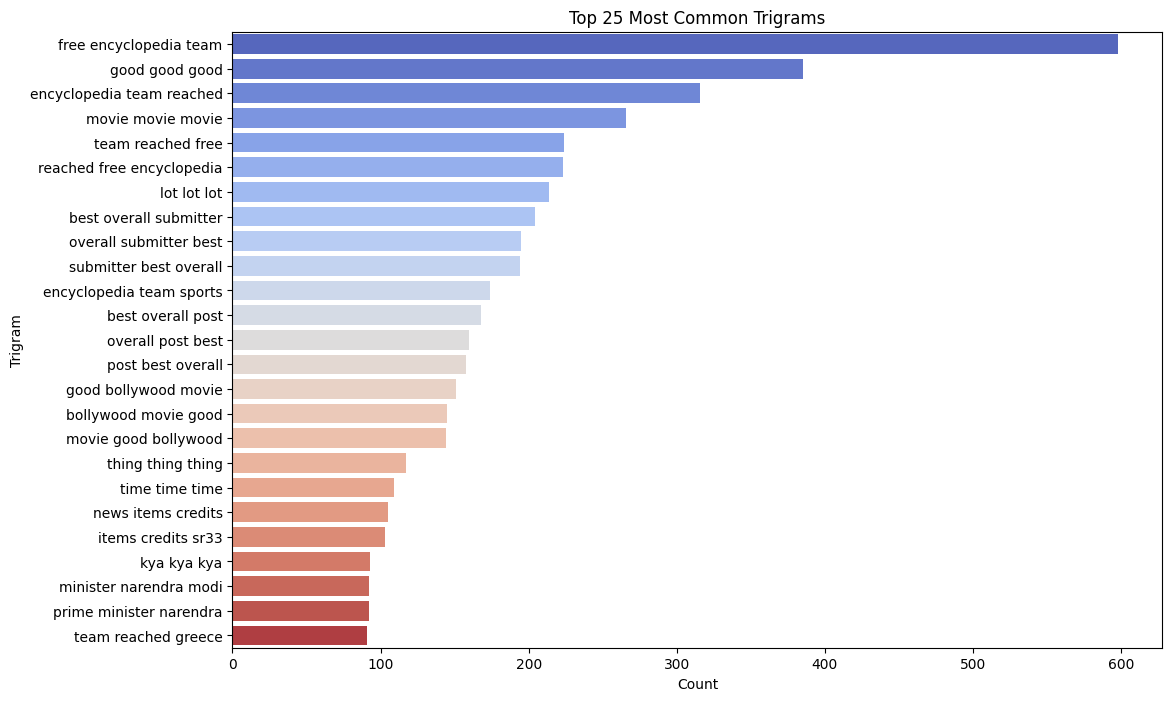

In [42]:
# Create a function to extract the top 25 trigrams
def get_top_trigrams(corpus, n=None):
    vec = CountVectorizer(ngram_range=(3, 3), stop_words='english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)
    return words_freq[:n]

# Get the top 25 trigrams
top_25_trigrams = get_top_trigrams(df['clean_comment'], 25)

# Convert the trigrams into a DataFrame for plotting
top_25_trigrams_df = pd.DataFrame(top_25_trigrams, columns=['trigram', 'count'])

# Plot the countplot for the top 25 trigrams
plt.figure(figsize=(12, 8))
sns.barplot(data=top_25_trigrams_df, x='count', y='trigram', palette='coolwarm')
plt.title('Top 25 Most Common Trigrams')
plt.xlabel('Count')
plt.ylabel('Trigram')
plt.show()

In [43]:
# Remove non-English characters from the 'clean_comment' column
# Keeping only standard English letters, digits, and common punctuation
df['clean_comment'] = df['clean_comment'].apply(lambda x: re.sub(r'[^A-Za-z0-9\s!?.,]', '', str(x)))

In [44]:
all_text = ' '.join(df['clean_comment'])

# Count the frequency of each character
char_frequency = Counter(all_text)

# Convert the character frequency into a DataFrame for better display
char_frequency_df = pd.DataFrame(char_frequency.items(), columns=['character', 'frequency']).sort_values(by='frequency', ascending=False)

char_frequency_df

,character,frequency
6,,1091592
12,e,666610
13,t,491287
1,a,481134
3,i,401388
9,n,388465
7,o,379908
17,s,355279
8,r,331425
10,h,296748


In [45]:
# Defining stop words but keeping essential ones for sentiment analysis
stop_words = set(stopwords.words('english')) - {'not', 'but', 'however', 'no', 'yet'}

# Remove stop words from 'clean_comment' column, retaining essential ones
df['clean_comment'] = df['clean_comment'].apply(
    lambda x: ' '.join([word for word in x.split() if word.lower() not in stop_words])
)

In [46]:
df.head()

,clean_comment,category,word_count,num_stop_words,num_chars,num_punctuation_chars
0,family mormon never tried explain still stare ...,1,39,13,259,0
1,buddhism much lot compatible christianity espe...,1,196,59,1268,0
2,seriously say thing first get complex explain ...,-1,86,40,459,0
3,learned want teach different focus goal not wr...,0,29,15,167,0
4,benefit may want read living buddha living chr...,1,112,45,690,0


In [47]:
from nltk.stem import WordNetLemmatizer

nltk.download('wordnet')

# Define the lemmatizer
lemmatizer = WordNetLemmatizer()

# Apply lemmatization to the 'clean_comment_no_stopwords' column
df['clean_comment'] = df['clean_comment'].apply(
    lambda x: ' '.join([lemmatizer.lemmatize(word) for word in x.split()])
)

df.head()

[nltk_data] Downloading package wordnet to
[nltk_data]     /home/sudarshan/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


,clean_comment,category,word_count,num_stop_words,num_chars,num_punctuation_chars
0,family mormon never tried explain still stare ...,1,39,13,259,0
1,buddhism much lot compatible christianity espe...,1,196,59,1268,0
2,seriously say thing first get complex explain ...,-1,86,40,459,0
3,learned want teach different focus goal not wr...,0,29,15,167,0
4,benefit may want read living buddha living chr...,1,112,45,690,0


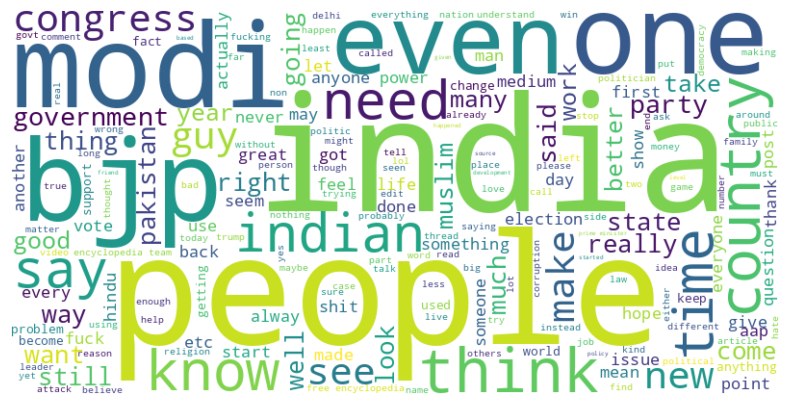

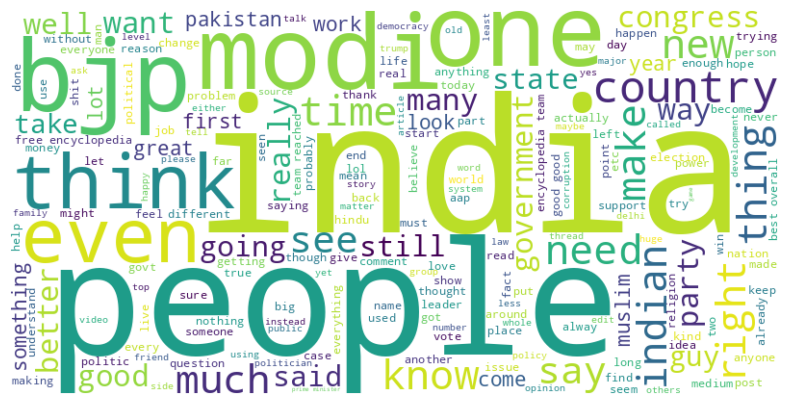

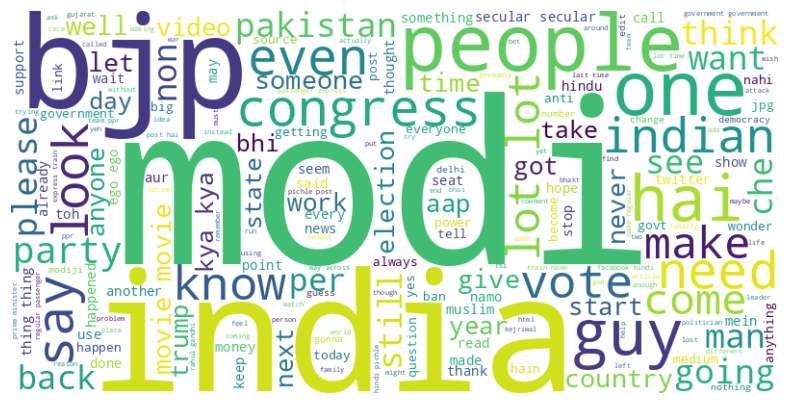

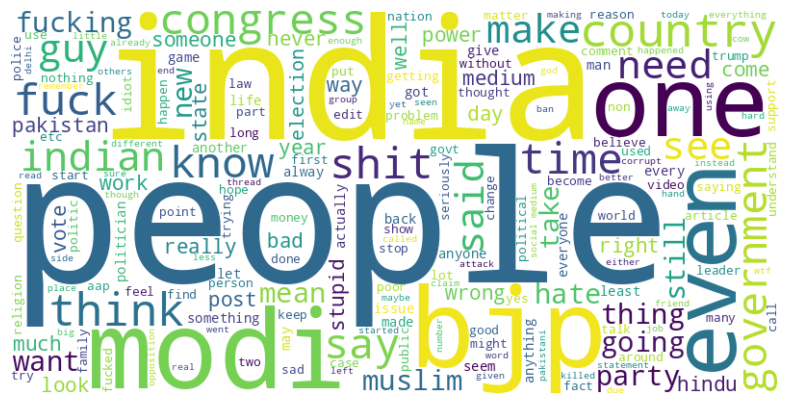

In [48]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

def plot_word_cloud(text):
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(' '.join(text))
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.show()

def plot_word_cloud(text):
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(' '.join(text))
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.show()

def plot_word_cloud(text):
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(' '.join(text))
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.show()

def plot_word_cloud(text):
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(' '.join(text))
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.show()

plot_word_cloud(df['clean_comment'])
plot_word_cloud(df[df['category'] == 1]['clean_comment'])
plot_word_cloud(df[df['category'] == 0]['clean_comment'])
plot_word_cloud(df[df['category'] == -1]['clean_comment'])

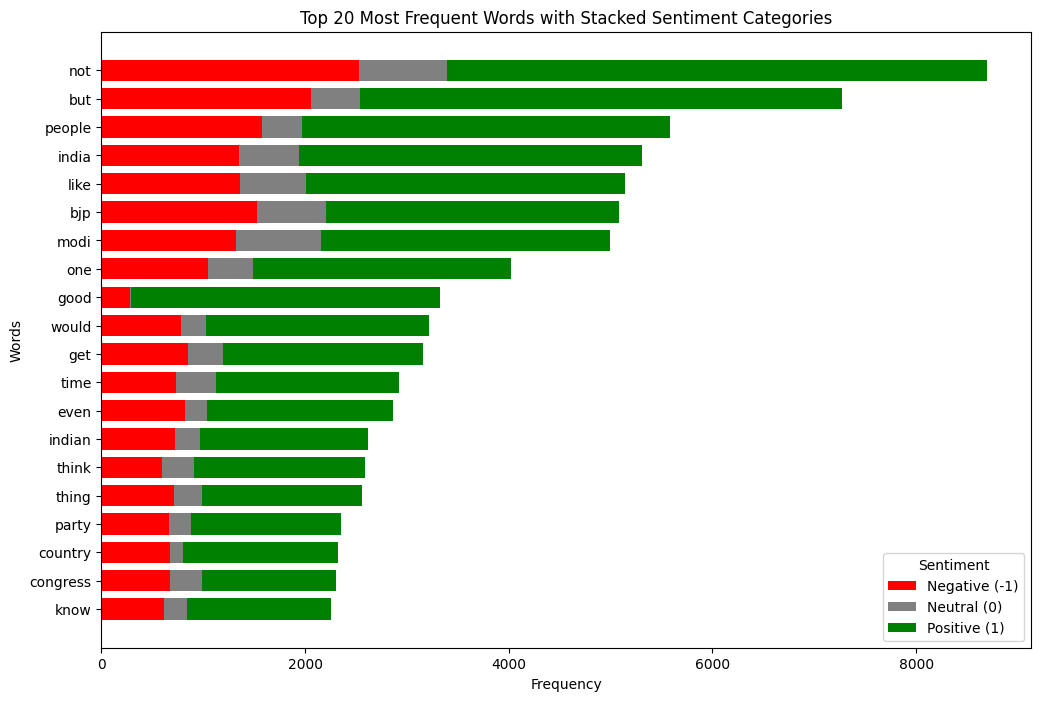

In [49]:
def plot_top_n_words_by_category(df, n=20, start=0):
    """Plot the top N most frequent words in the dataset with stacked hue based on sentiment category."""
    # Flatten all words in the content column and count their occurrences by category
    word_category_counts = {}

    for idx, row in df.iterrows():
        words = row['clean_comment'].split()
        category = row['category']  # Assuming 'category' column exists for -1, 0, 1 labels

        for word in words:
            if word not in word_category_counts:
                word_category_counts[word] = { -1: 0, 0: 0, 1: 0 }  # Initialize counts for each sentiment category

            # Increment the count for the corresponding sentiment category
            word_category_counts[word][category] += 1

    # Get total counts across all categories for each word
    total_word_counts = {word: sum(counts.values()) for word, counts in word_category_counts.items()}

    # Get the top N most frequent words across all categories
    most_common_words = sorted(total_word_counts.items(), key=lambda x: x[1], reverse=True)[start:start+n]
    top_words = [word for word, _ in most_common_words]

    # Prepare data for plotting
    word_labels = top_words
    negative_counts = [word_category_counts[word][-1] for word in top_words]
    neutral_counts = [word_category_counts[word][0] for word in top_words]
    positive_counts = [word_category_counts[word][1] for word in top_words]

    # Plot the stacked bar chart
    plt.figure(figsize=(12, 8))
    bar_width = 0.75

    # Plot negative, neutral, and positive counts in a stacked manner
    plt.barh(word_labels, negative_counts, color='red', label='Negative (-1)', height=bar_width)
    plt.barh(word_labels, neutral_counts, left=negative_counts, color='gray', label='Neutral (0)', height=bar_width)
    plt.barh(word_labels, positive_counts, left=[i+j for i,j in zip(negative_counts, neutral_counts)], color='green', label='Positive (1)', height=bar_width)

    plt.xlabel('Frequency')
    plt.ylabel('Words')
    plt.title(f'Top {n} Most Frequent Words with Stacked Sentiment Categories')
    plt.legend(title='Sentiment', loc='lower right')
    plt.gca().invert_yaxis()  # Invert y-axis to show the highest frequency at the top
    plt.show()



plot_top_n_words_by_category(df, n=20)